### This notebook analyzes the effect of motif length on motif detection

In [1]:
# Install required packages
!pip install ipynb
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.9 MB/s 


In [2]:
# Import necessary libraries
import random
import time
import numpy as np
import math
from google.colab import drive

In [3]:
# Establish connection to use Google drive
drive.mount("/content/drive")
base_path = "drive/MyDrive/Motif-Detection/"
input_path = base_path + "Data/"
result_path = base_path + "Motif-Length-Analysis/"

# Define path to fetch the ipynb file
import sys
sys.path.insert(1, r'/content/drive/MyDrive/Motif-Detection/Py-files/Utils/')

# Import ipynb needed to access required functions
import import_ipynb
from info_content_ops import compute_information_content
from file_io import read_sequences_from_input_file, save_prediction_results_to_respective_files
from visualization import find_count_of_threshold_matched_sequences, compute_normalized_motif_counts, plot_motif_match_observations


Mounted at /content/drive


In [4]:
# Function to compute the Position Weight Matrix (PWM) for N-1 sequences
# Input: dna_seqeunces, no_of_sequences, motif_length, sequence_length, motif_sites 
# Output: Returns pwm and ignored sequence

def compute_position_weight_matrix(dna_seqs, no_of_seqs, motif_len, seq_len, motif_sites):

  # To ignore a sequence, we generate a random number
  random.seed(time.time())
  ignored_seq = random.randrange(0, no_of_seqs)

  # Calculating the PWM
  # Rows: 4 representing A, G, T, C respectively
  # Columns: As many as the motif length
  pwm = np.zeros((4, motif_len))

  # Indexing the N-1 sequences
  idx = 0

  for seq_idx in range(0, no_of_seqs):

    # We ignore the previously selected random sequence
    if seq_idx == ignored_seq:
        continue

    else:
      for m_len in range(0, motif_len):
        value = dna_seqs[seq_idx][motif_sites[idx] + m_len]
        if value == nucleotides[0]:
          pwm[0][m_len] += 1
        elif value == nucleotides[1]:
          pwm[1][m_len] += 1
        elif value == nucleotides[2]:
          pwm[2][m_len] += 1
        elif value == nucleotides[3]:
          pwm[3][m_len] += 1
    idx += 1

  return pwm/(no_of_seqs - 1), ignored_seq


In [5]:
# Function to find max PWM and max info content
# Input: iterations, dna_sequences, motif_length, sequence_length, motif_sites
# Output: Returns information content, pwm and information vector

def compute_max_pwm_and_ic(iterations, dna_sequences, motif_length, sequence_length, motif_sites, acceptable_info_content = 1.7):

  # Declaring required variables
  added_prediction, max_info_content, iter_count = False, 0, 0
  information_vector = [['IC'], ['sites']]
  no_of_seqs = len(dna_sequences)
  
  print("Iterations to be completed: ", iterations)

  # Runs multiple iterations to obtain right values
  for iteration in range(0, iterations):
    
    # Tracking iterations
    iter_count += 1
    if iter_count % 100 == 0:
      print("Completed ", iter_count, " iterations")

    # Finding the Position Weight Matrix (PWM) for N-1 sequences
    pwm, ignored_seq = compute_position_weight_matrix(dna_sequences, no_of_seqs, motif_length, sequence_length, motif_sites)

    # Predicting the site in the ignored sequence using the PWM
    predicted_site_in_ignored_seq = predict_motif_site_in_ignored_seq(dna_sequences, ignored_seq, pwm, motif_length, sequence_length)

    # Adding the predicted site to the list if it is not yet added
    if added_prediction == False:
      motif_sites.insert(ignored_seq, predicted_site_in_ignored_seq)
      added_prediction = True
    else:
      motif_sites[ignored_seq] = predicted_site_in_ignored_seq
    motif_sites_temp = motif_sites[:]

    # Computing the information content of the prediction in the current iteration
    information_vector[1].append(motif_sites_temp)
    info_content, pwm = compute_information_content(nucleotides, freq, motif_sites, dna_sequences, motif_length, no_of_seqs, pwm)
    information_vector[0].append(info_content)

    # Updating max. information content value
    if info_content > max_info_content:
      max_info_content = info_content
      max_pwm = pwm

    if info_content > (acceptable_info_content * motif_length):
      break

  # Updating info_content & pwm with the max. values respectively
  info_content = max_info_content
  pwm = max_pwm
  
  return info_content, max_pwm, information_vector


In [6]:
# Function to predict the motif_site in ignored sequence using the Position Weight Matrix
# Input: dna_seqeunces, ignored_seq, pwm, motif_length, sequence_length
# Output: Returns the predicted site

def predict_motif_site_in_ignored_seq(dna_sequences, ignored_seq, pwm, motif_len, sequence_len):

  # Obtaining all possible prediction candidates of given motif length
  prediction_candidates = []
  for i in range(0, sequence_len - motif_len + 1):
    prediction_candidates.append((dna_sequences[ignored_seq])[i:i + motif_len])

  # Generating probabilities for all candidates to find the best possible prediction
  candidate_probabilities = []
  for pred_idx in range(0, len(prediction_candidates)):
    frequency, weighted_frequency = 1, 1

    for m_len in range(0, motif_len):
      value = prediction_candidates[pred_idx][m_len]
      if value == nucleotides[0]:
        frequency *= freq[0]
        weighted_frequency *= pwm[0][m_len]
      elif value == nucleotides[1]:
        frequency *= freq[1]
        weighted_frequency *= pwm[1][m_len]
      elif value == nucleotides[2]:
        frequency *= freq[2]
        weighted_frequency *= pwm[2][m_len]
      elif value == nucleotides[3]:
        frequency *= freq[3]
        weighted_frequency *= pwm[3][m_len]
    candidate_probabilities.append(weighted_frequency / frequency)

  # Normalizing the probabilities to obtain the predicted site
  normalized_probabilities = list(candidate_probabilities / sum(candidate_probabilities))
  predicted_site = normalized_probabilities.index(max(normalized_probabilities))
  return predicted_site


In [7]:
# Function to find motif from pwm using the sequences and motif length
# Input: pwm, no_of_seqs, motif_length
# Output: Returns motif result and profile matrix

def find_motif_from_pwm(pwm, no_of_seqs, motif_length):

  # Obtaining the motif from given dna sequences using Position Weight Matrix
  profile_matrix = np.transpose(pwm) * no_of_seqs
  motif_temp = []
  for m_len in range(0, motif_length):
    values_at_mlen = list(profile_matrix[m_len])
    max_value = max(values_at_mlen)

    # As two nucleotides may have equal probability of occurrence, we check if the max_value appears more than once
    max_value_indices = []
    for idx in range(0, len(values_at_mlen)):
      if values_at_mlen[idx] == max_value:
        max_value_indices.append(idx)
    
    if len(max_value_indices) > 1:
      motif_index = random.choice(max_value_indices)
    else:
      motif_index = values_at_mlen.index(max(values_at_mlen))
    
    motif_temp.append(nucleotides[motif_index])
  motif_result = ''.join(motif_temp)

  return motif_result, profile_matrix


In [8]:
# Define required variables
nucleotides = ['A','G','T','C']
freq = [0.25, 0.25, 0.25, 0.25]
sequence_length = 300   # Fixed: As the DNA contains 150 base pairs in general
motif_lengths = [10, 15, 20, 25, 30, 35, 40]   # Motifs are generally 5-20 pairs long
sequence_counts = [1000, 5000, 10000, 50000, 100000]
info_content = 1.75


In [9]:
# For various information content values, we analyze the results
motif_results_per_motif_length = {}

for motif_length in motif_lengths:
  print("\n\nMOTIF LENGTH: ", motif_length, "\n")

  # Executing Gibbs algorithm and store motif results obtained
  motif_results, profile_matrices, all_dna_sequences = [], [], []
  idx = 0

  for sequence_count in sequence_counts:

    # Read DNA data from input files
    dna_sequences = read_sequences_from_input_file(input_path, sequence_count)
    all_dna_sequences.append(dna_sequences)
    
    no_of_seqs = len(dna_sequences)
    print("No. of DNA sequences: ", no_of_seqs)

    # As in Gibbs sampling, we select random starting points and 
    # generate motif site for all the remaining sequences
    motif_sites = []
    for i in range(0, no_of_seqs-1):
      random_start_site = random.randrange(0, sequence_length - motif_length)
      motif_sites.append(random_start_site)

    # Implementing Gibbs algorithm with several iterations
    # Fixed to analyze ic effect
    iterations = 100
    info_content, pwm, information_vector = compute_max_pwm_and_ic(iterations, dna_sequences, motif_length, sequence_length, motif_sites, info_content)
    motif_result, profile_matrix = find_motif_from_pwm(pwm, no_of_seqs, motif_length)
    motif_results.append(motif_result)
    profile_matrices.append(profile_matrix)
    save_prediction_results_to_respective_files(result_path, motif_result, sequence_count, information_vector, profile_matrix)

    # Analyzing the results obtained
    print("Motif discovered: ", motif_results[idx], "\n")
    print("-----------------------\n")
    idx += 1

  # Finding motif counts for various motif length values
  motif_counts = find_count_of_threshold_matched_sequences(all_dna_sequences, motif_results)
  normalized_motif_counts = compute_normalized_motif_counts(motif_counts)
  motif_results_per_motif_length[motif_length] = [normalized_motif_counts, motif_results]
  print("\n****************************************")




MOTIF LENGTH:  10 

No. of DNA sequences:  1000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  GGCATTCTTC 

-----------------------

No. of DNA sequences:  5000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  AGAAGATGGC 

-----------------------

No. of DNA sequences:  10000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  TCGAGCCCCC 

-----------------------

No. of DNA sequences:  50000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  CACTTTCGCG 

-----------------------

No. of DNA sequences:  100000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  GGCACACAAT 

-----------------------

Original motif counts:
[61, 68, 65, 65, 61] for  1000  dna sequences
[306, 293, 321, 326, 306] for  5000  dna sequences
[603, 662, 618, 607, 603] for  10000  dna sequences
[3111, 3094, 3062, 3163, 3111] for  50000  dna sequences
[6265, 6118, 6340, 6

FOR MOTIF LENGTH:  10


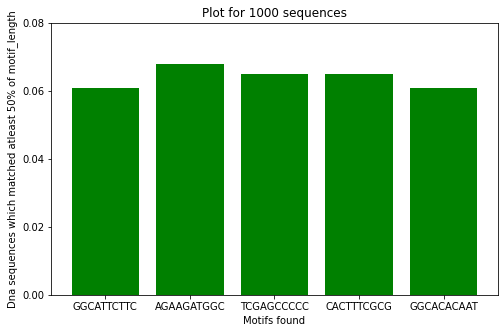

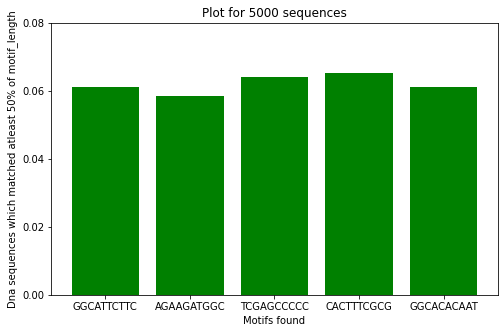

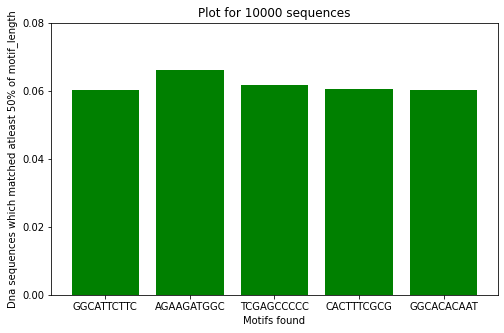

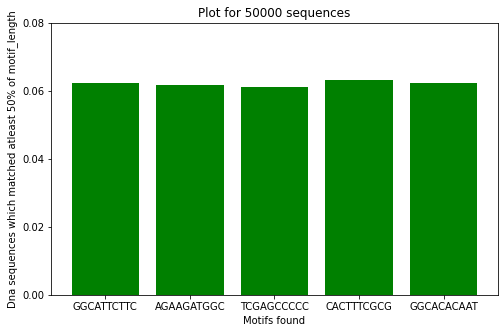

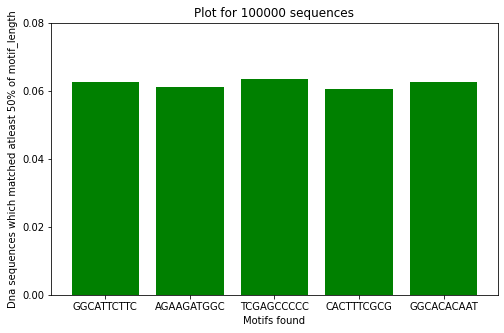

FOR MOTIF LENGTH:  15


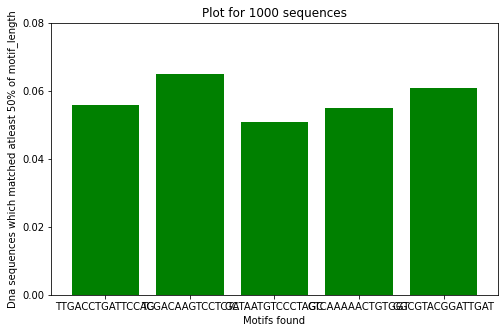

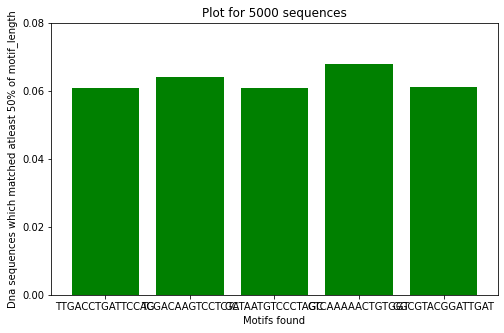

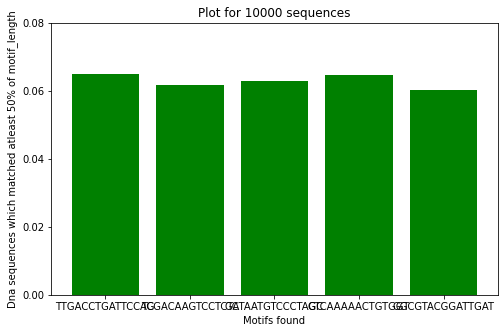

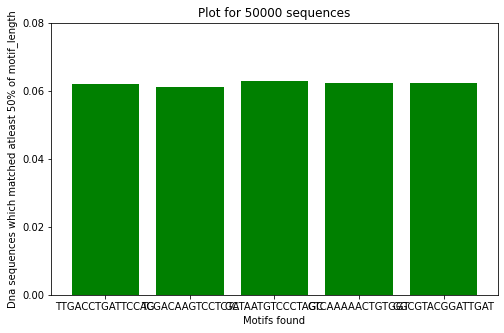

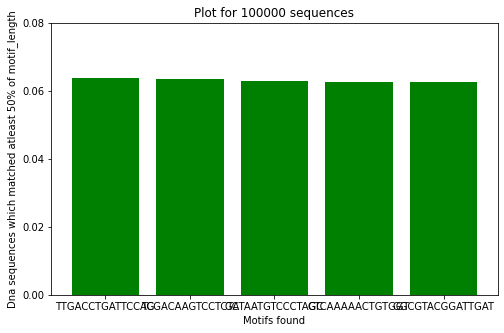

FOR MOTIF LENGTH:  20


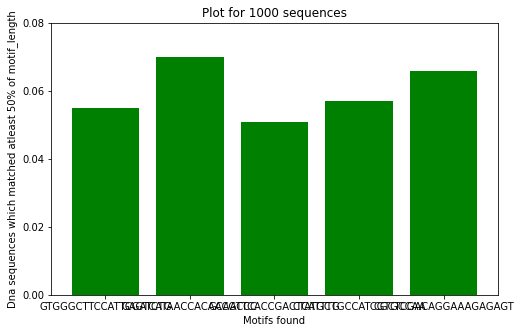

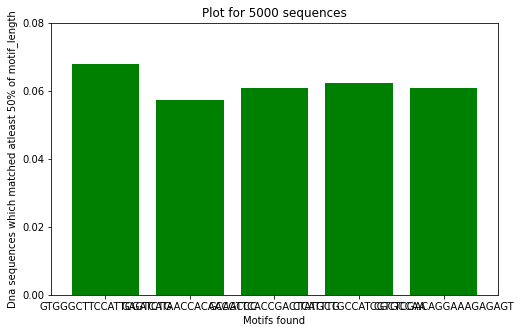

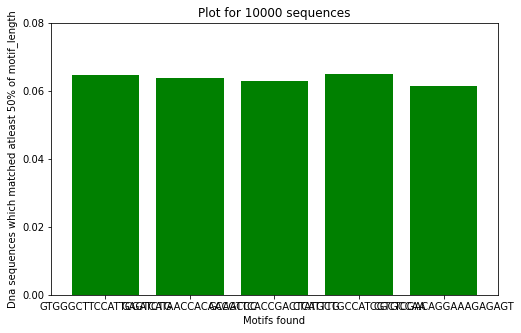

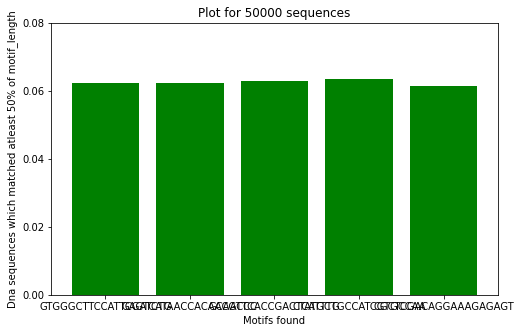

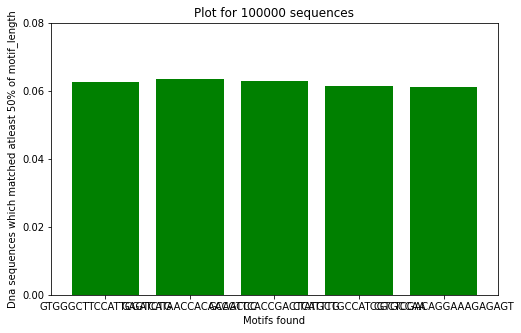

FOR MOTIF LENGTH:  25


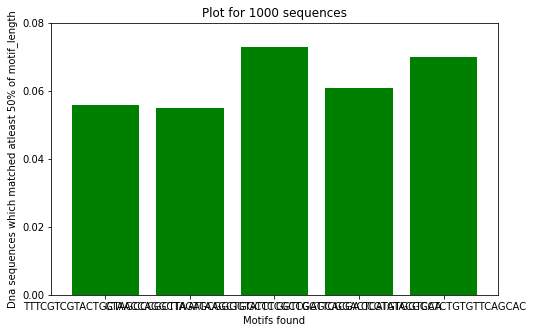

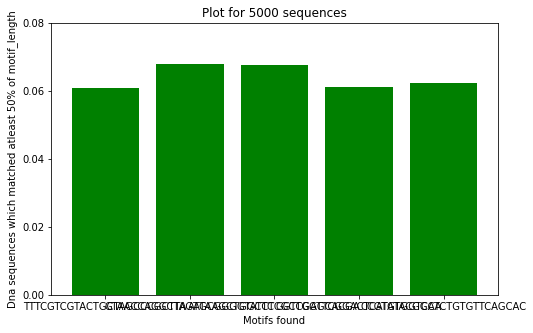

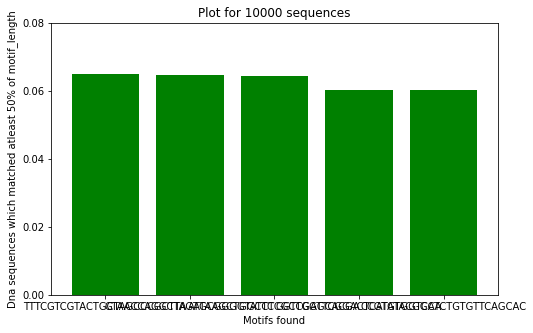

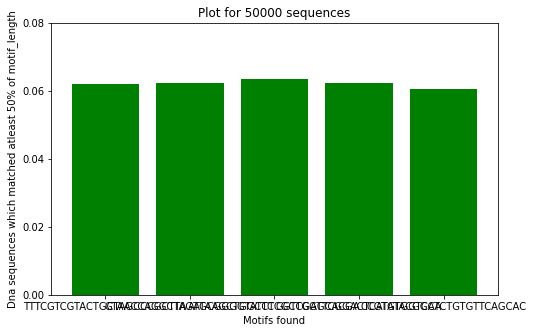

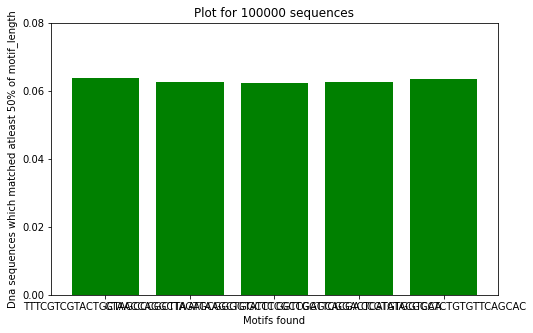

FOR MOTIF LENGTH:  30


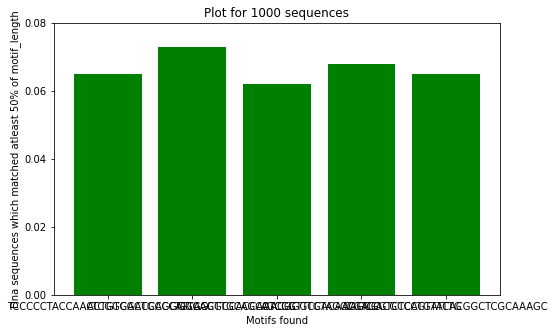

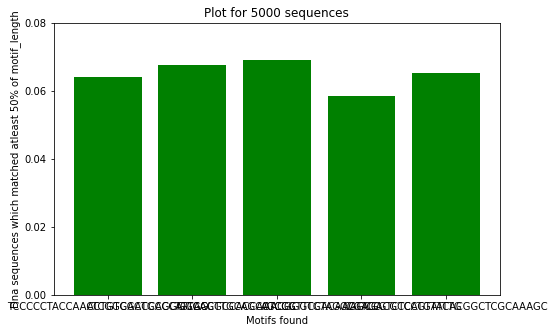

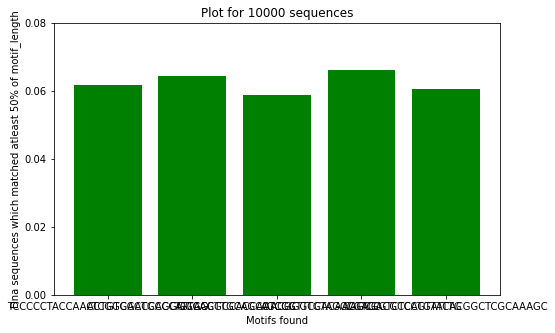

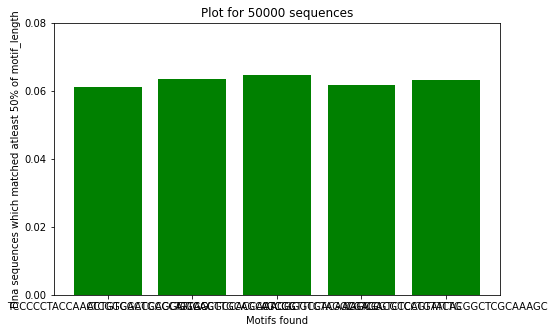

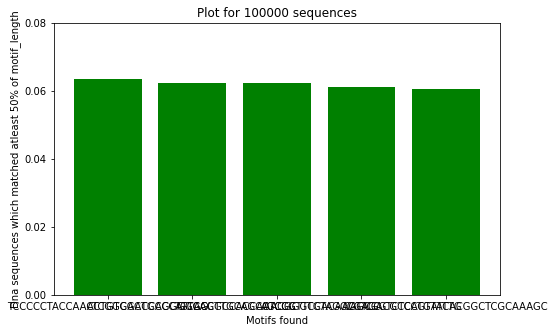

FOR MOTIF LENGTH:  35


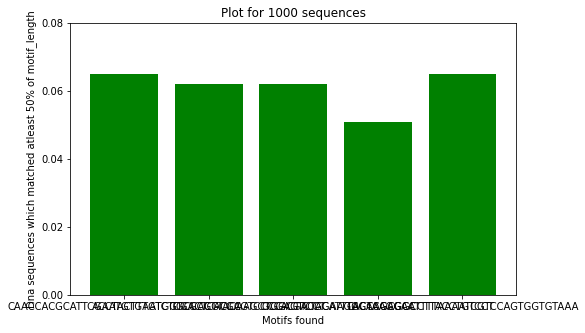

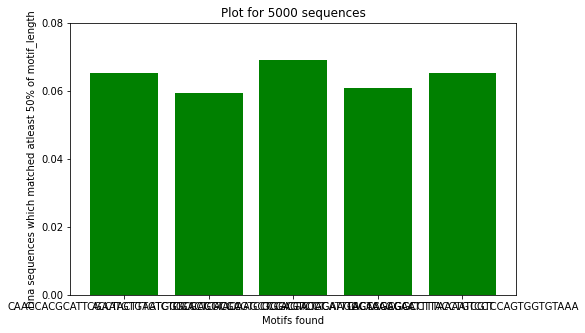

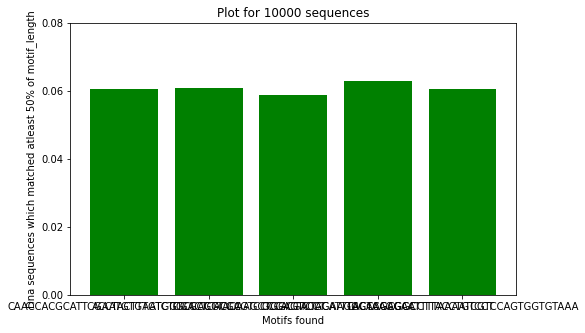

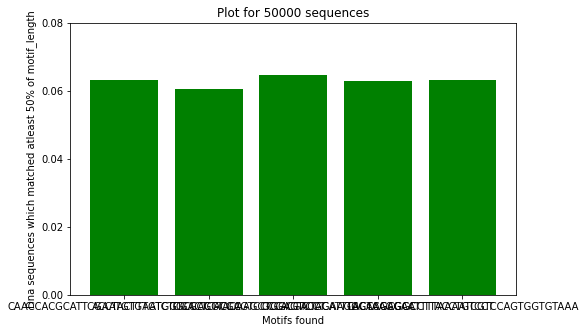

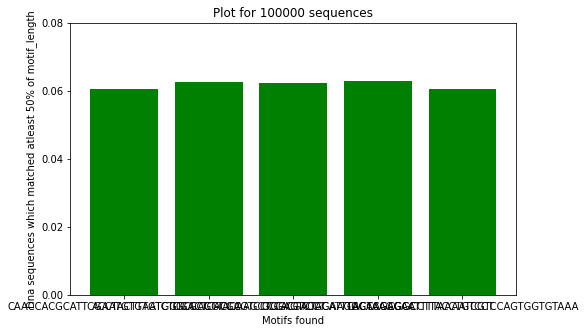

FOR MOTIF LENGTH:  40


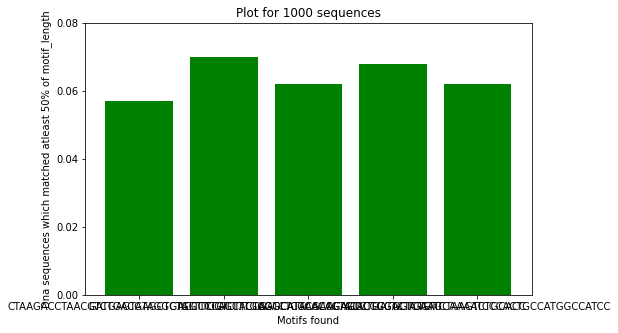

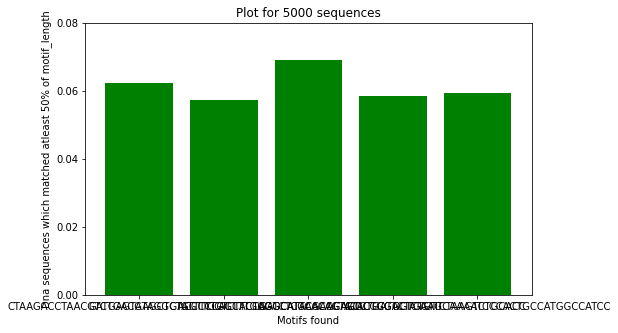

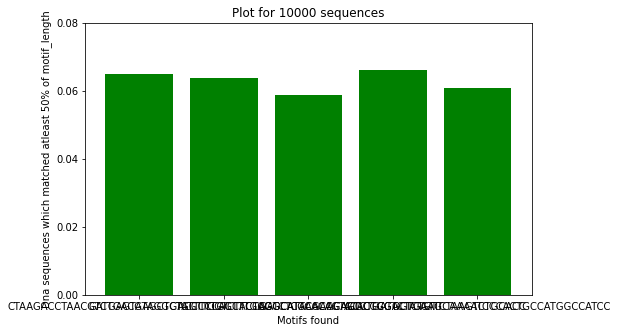

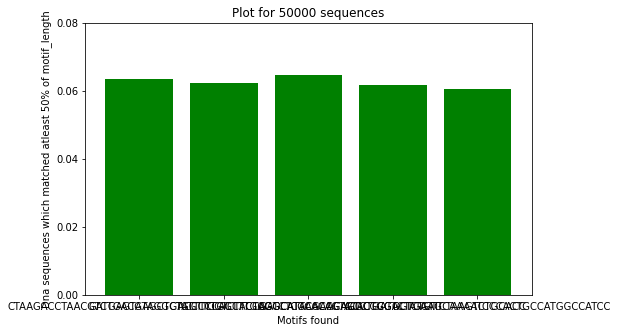

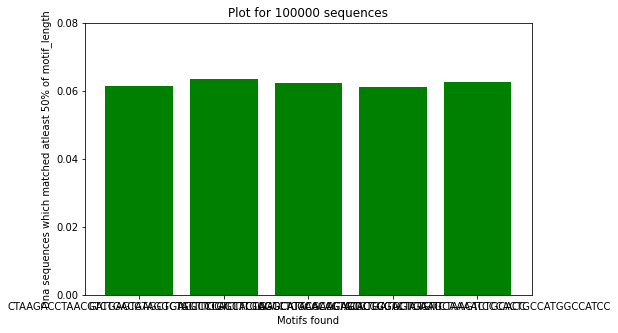

In [10]:
# Plot analysis results per icv
# <motif_length: [{data_size: [normalized_probs], <>}]>
for motif_length in motif_results_per_motif_length:
  print("FOR MOTIF LENGTH: ", motif_length)
  data_and_normalized_vals = motif_results_per_motif_length[motif_length][0]
  motifs_found = motif_results_per_motif_length[motif_length][1]
  for data_size in data_and_normalized_vals:
    data_and_normalized_vals_dict = {data_size : data_and_normalized_vals[data_size]}
    plot_motif_match_observations(motifs_found, data_and_normalized_vals_dict)
print("\n\n")
